In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import warp
from skimage.util import img_as_float
from warnings import warn
from scipy.fftpack import fft, ifft

RADON TRANSFORM:

In [ ]:
def radon(image, theta, circle=True):
    if image.ndim != 2:
        raise ValueError('The input image must be 2-D')

    image = img_as_float(image)

    if circle:
        shape_min = min(image.shape)
        radius = shape_min // 2
        img_shape = np.array(image.shape)
        coords = np.array(np.ogrid[: image.shape[0], : image.shape[1]], dtype=object)
        dist = ((coords - img_shape // 2) ** 2).sum(0)
        if np.any(image[dist > radius**2]):
            warn('Image must be zero outside the reconstruction circle')
        slices = tuple(slice(int(np.ceil(excess / 2)), int(np.ceil(excess / 2) + shape_min)) if excess > 0 else slice(None) for excess in (img_shape - shape_min))
        padded_image = image[slices]
    else:
        diagonal = np.sqrt(2) * max(image.shape)
        pad = [int(np.ceil(diagonal - s)) for s in image.shape]
        new_center = [(s + p) // 2 for s, p in zip(image.shape, pad)]
        old_center = [s // 2 for s in image.shape]
        pad_before = [nc - oc for oc, nc in zip(old_center, new_center)]
        pad_width = [(pb, p - pb) for pb, p in zip(pad_before, pad)]
        padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)

    if padded_image.shape[0] != padded_image.shape[1]:
        raise ValueError('padded_image must be a square')
    center = padded_image.shape[0] // 2
    radon_image = np.zeros((padded_image.shape[0], len(theta)), dtype=image.dtype)

    for i, angle in enumerate(np.deg2rad(theta)):
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        R = np.array([[cos_a, sin_a, -center * (cos_a + sin_a - 1)], [-sin_a, cos_a, -center * (cos_a - sin_a - 1)], [0, 0, 1]])
        rotated = warp(padded_image, R, clip=False)
        radon_image[:, i] = rotated.sum(0)

    return radon_image

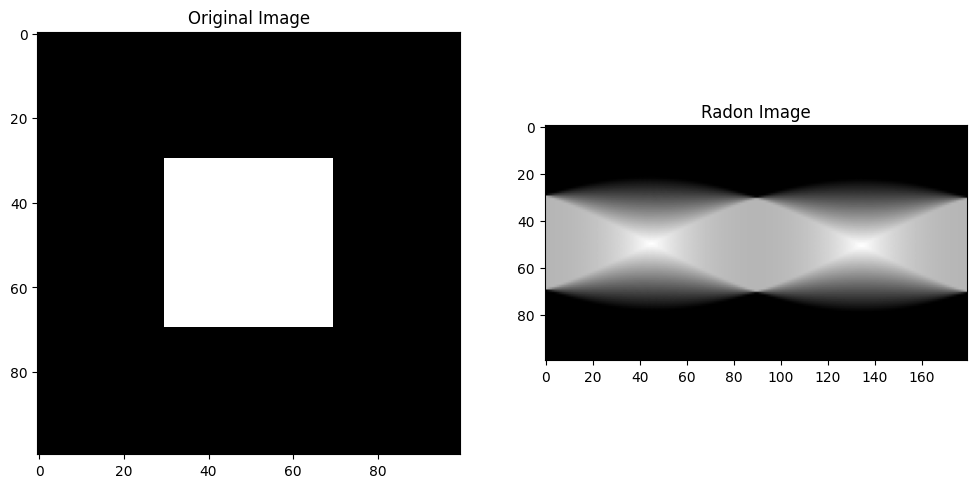

In [ ]:
image_test = np.zeros((100,100))
image_test[30:70,30:70] = 1
radon_image_test = radon(image_test,np.linspace(0,180,180))
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.imshow(image_test, cmap ="gray")
plt.title("Original Image")
#plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(radon_image_test, cmap ="gray")
plt.title("Radon Image")
#plt.axis("off")
plt.show()

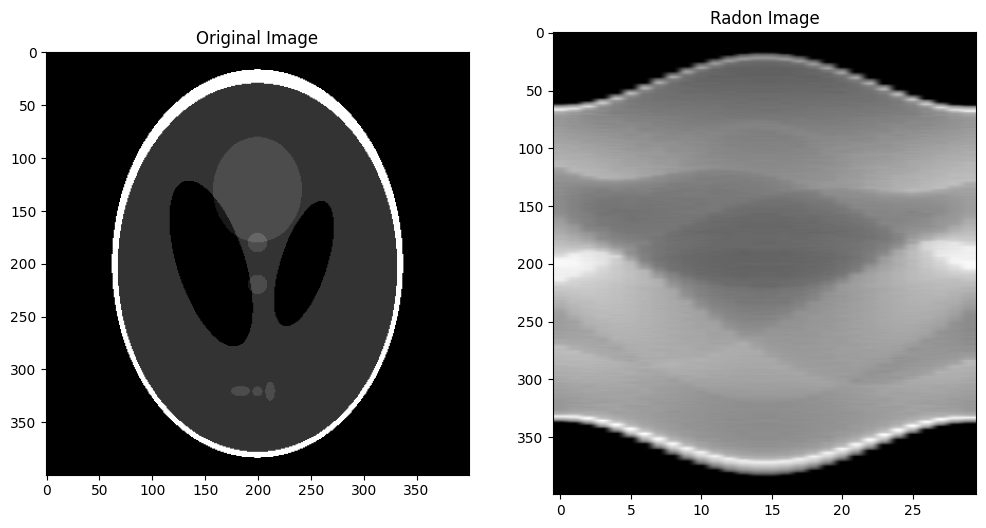

In [ ]:
from skimage.data import shepp_logan_phantom
image_test_2 = shepp_logan_phantom()
theta = np.linspace(0,180,30)
radon_image_test_2 = radon(image_test_2,theta)
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.imshow(image_test_2, cmap ="gray")
plt.title("Original Image")
#plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(radon_image_test_2, cmap ="gray",aspect='auto')
plt.title("Radon Image")
#plt.axis("off")
plt.show()

INVERSE RADON TRANSFORM:

In [ ]:
import numpy as np
from scipy.fftpack import fft, ifft
from skimage.util import img_as_float

def iradon(radon_image, theta, circle=True):
    if radon_image.ndim != 2:
        raise ValueError('The input image must be 2-D')

    if theta is None:
        theta = np.linspace(0, 180, radon_image.shape[1], endpoint=False)

    angles_count = len(theta)
    if angles_count != radon_image.shape[1]:
        raise ValueError("The given ``theta`` does not match the number of projections in ``radon_image``.")

    radon_image = img_as_float(radon_image)

    img_shape = radon_image.shape[0]
    output_size = img_shape

    projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * img_shape))))
    pad_width = ((0, projection_size_padded - img_shape), (0, 0))
    img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

    # Apply ramp filter in Fourier domain
    f = 2 * np.abs(np.fft.fftfreq(projection_size_padded))
    fourier_filter = f[:, np.newaxis]
    projection = fft(img, axis=0) * fourier_filter
    radon_filtered = np.real(ifft(projection, axis=0)[:img_shape, :])

    reconstructed = np.zeros((output_size, output_size), dtype=radon_image.dtype)
    radius = output_size // 2
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape) - img_shape // 2

    for col, angle in zip(radon_filtered.T, np.deg2rad(theta)):
        t = ypr * np.cos(angle) - xpr * np.sin(angle)
        interpolant = np.interp(t, x, col, left=0, right=0)
        reconstructed += interpolant

    if circle:
        out_reconstruction_circle = (xpr**2 + ypr**2) > radius**2
        reconstructed[out_reconstruction_circle] = 0.0

    return reconstructed * np.pi / (2 * angles_count)



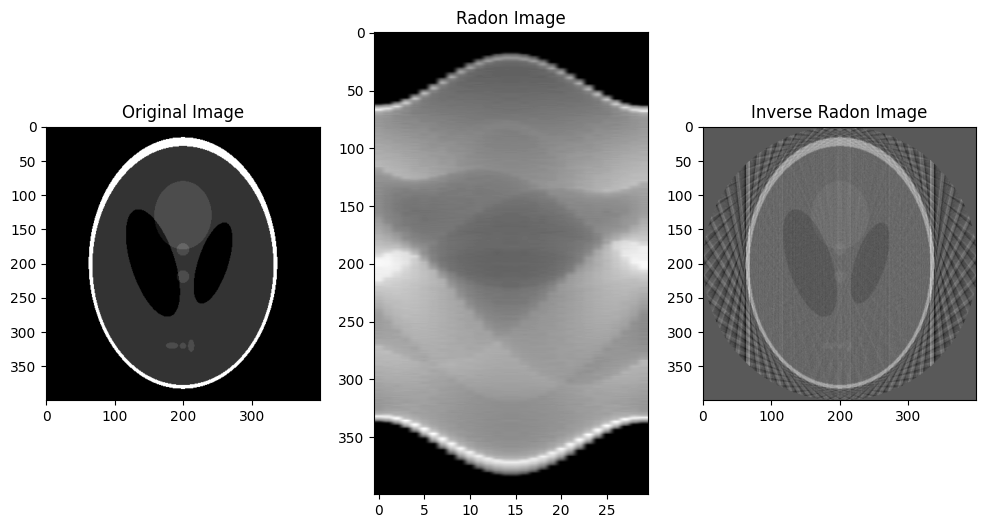

In [ ]:
from skimage.data import shepp_logan_phantom
image_test_2 = shepp_logan_phantom()
theta = np.linspace(0,180,30)
radon_image_test_2 = radon(image_test_2,theta)
plt.figure(figsize= (12,6))
plt.subplot(1,3,1)
plt.imshow(image_test_2, cmap ="gray")
plt.title("Original Image")
#plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(radon_image_test_2, cmap ="gray",aspect='auto')
plt.title("Radon Image")
#plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(iradon(radon_image_test_2,theta), cmap ="gray")
plt.title("Inverse Radon Image")
#plt.axis("off")
plt.show()

In [ ]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.2 MB/s eta 0:00:00


PERFORMING ON DATA:

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage.transform import resize, radon, iradon
import zipfile
import shutil

# Define file paths
input_zip_path = '/content/OBJECTS.zip'  # Path to your zip file
output_folder_path_1 = 'file_1'  # Path for file_1 (combined images)
output_folder_path_2 = 'file_2'  # Path for file_2 (sinogram images)
output_folder_path_3 = 'file_3'  # Path for file_3 (reconstructed images)

# Create output directories if they don't exist
os.makedirs(output_folder_path_1, exist_ok=True)
os.makedirs(output_folder_path_2, exist_ok=True)
os.makedirs(output_folder_path_3, exist_ok=True)

# List of projection angles to use
projections_list = [30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]

# Extract DICOM files from the zip file
with zipfile.ZipFile(input_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dicom_files')

# Now, the files are inside /content/dicom_files/OBJECTS

# Process each DICOM file in the OBJECTS folder
objects_folder = '/content/dicom_files/OBJECTS'
for index, dicom_file in enumerate(os.listdir(objects_folder)):
    if dicom_file.endswith('.dcm'):
        # Read the DICOM file
        dicom_path = os.path.join(objects_folder, dicom_file)
        dicom_data = pydicom.dcmread(dicom_path)
        original_image = dicom_data.pixel_array

        # Resize the original image to a fixed size (256x256)
        original_image_resized = resize(original_image, (256, 256), mode='reflect', anti_aliasing=True)

        # Create subfolders in output directories for each DICOM file
        subfolder_1 = os.path.join(output_folder_path_1, f'Object_{index + 1}')
        subfolder_2 = os.path.join(output_folder_path_2, f'Sinogram_{index + 1}')
        subfolder_3 = os.path.join(output_folder_path_3, f'Reconstructed_{index + 1}')

        os.makedirs(subfolder_1, exist_ok=True)
        os.makedirs(subfolder_2, exist_ok=True)
        os.makedirs(subfolder_3, exist_ok=True)

        # Create a figure to save the combined images (for file_1)
        fig_combined_images = plt.figure(figsize=(20, len(projections_list) * 5))

        # Process each projection angle
        for i, projections in enumerate(projections_list):
            theta = np.linspace(0, 180, projections)
            sinogram = radon(original_image_resized, theta)
            reconstructed_image = iradon(sinogram, theta)

            # Save combined images (original + sinogram + reconstructed) to file_1
            ax1 = fig_combined_images.add_subplot(len(projections_list), 3, i * 3 + 1)
            ax1.imshow(original_image_resized, cmap='gray')
            ax1.set_title(f'Original Image')
            ax1.axis('off')

            ax2 = fig_combined_images.add_subplot(len(projections_list), 3, i * 3 + 2)
            ax2.imshow(sinogram, cmap='gray')
            ax2.set_title(f'Sinogram ({projections} Projections)')
            ax2.axis('off')

            ax3 = fig_combined_images.add_subplot(len(projections_list), 3, i * 3 + 3)
            ax3.imshow(reconstructed_image, cmap='gray')
            ax3.set_title(f'Reconstructed Image ({projections} Projections)')
            ax3.axis('off')

            # Save the combined images to file_1
            combined_image_path = os.path.join(subfolder_1, f'{dicom_file}_combined_{projections}.png')
            fig_combined_images.savefig(combined_image_path)
            plt.close(fig_combined_images)

            # Save only the reconstructed image to file_2
            fig_reconstructed_image = plt.figure()
            plt.imshow(reconstructed_image, cmap='gray')
            plt.axis('off')
            reconstructed_image_path = os.path.join(subfolder_2, f'sinogram_{projections}.png')
            fig_reconstructed_image.savefig(reconstructed_image_path)
            plt.close(fig_reconstructed_image)

            # Save only the sinogram to file_3
            sinogram_image_path = os.path.join(subfolder_3, f'reconstructed_{projections}.png')
            fig_sinogram = plt.figure()
            plt.imshow(sinogram, cmap='gray')
            plt.axis('off')
            fig_sinogram.savefig(sinogram_image_path)
            plt.close(fig_sinogram)

# Zip the output directories
shutil.make_archive(output_folder_path_1, 'zip', output_folder_path_1)
shutil.make_archive(output_folder_path_2, 'zip', output_folder_path_2)
shutil.make_archive(output_folder_path_3, 'zip', output_folder_path_3)

/usr/local/lib/python3.10/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


'/content/file_3.zip'

PERFORMANCE:

In [ ]:
import os
import numpy as np
import pydicom
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.transform import resize

# Define the paths
objects_folder = '/content/dicom_files/OBJECTS'
projections_list = [30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]

# Get all DICOM files
dicom_files = [f for f in os.listdir(objects_folder) if f.endswith('.dcm')]
num_files = len(dicom_files)

# Initialize matrices to store PSNR and SSIM values
psnr_matrix = np.zeros((len(projections_list), num_files))
ssim_matrix = np.zeros((len(projections_list), num_files))

# Process each DICOM file
for file_index, dicom_file in enumerate(dicom_files):
    dicom_path = os.path.join(objects_folder, dicom_file)
    dicom_data = pydicom.dcmread(dicom_path)
    original_image = dicom_data.pixel_array

    # Resize the original image to a fixed size (256x256)
    original_image_resized = resize(original_image, (256, 256), mode='reflect', anti_aliasing=True)

    # Process each projection angle
    for proj_index, projections in enumerate(projections_list):
        theta = np.linspace(0, 180, projections, endpoint=False)

        # Perform Radon transform and reconstruction
        sinogram = radon(original_image_resized, theta, circle=True)
        reconstructed_image = iradon(sinogram, theta, circle=True)

        # Calculate PSNR
        psnr_value = peak_signal_noise_ratio(original_image_resized, reconstructed_image)
        psnr_matrix[proj_index, file_index] = psnr_value

        # Calculate SSIM
        ssim_value = structural_similarity(
            original_image_resized, reconstructed_image,
            data_range=original_image_resized.max() - original_image_resized.min()
        )
        ssim_matrix[proj_index, file_index] = ssim_value

# Display PSNR and SSIM matrices
print("PSNR Matrix:")
print(psnr_matrix)

print("\nSSIM Matrix:")
print(ssim_matrix)

# Save PSNR and SSIM matrices to CSV
np.savetxt("psnr_matrix.csv", psnr_matrix, delimiter=",", header=",".join(map(str, projections_list)))
np.savetxt("ssim_matrix.csv", ssim_matrix, delimiter=",", header=",".join(map(str, projections_list)))

PSNR Matrix:
[[40.47086662 40.53137651 40.51743299 40.43380215 40.52573465 40.50868765
  40.44395713 40.47943119 40.48174235 40.46919404 40.44581812 40.4386909
  40.48929423 40.38247763 40.5177897  40.53355483 40.47328862 40.460216
  40.52304088 40.5074919  40.51563009 40.45774731 40.52274722 40.47035098
  40.50303615 40.43580506 40.40772578 40.4643309  40.48316785 40.4560749 ]
 [40.84187921 40.88015296 40.87059658 40.83836199 40.87681351 40.86821365
  40.83254473 40.85807697 40.86304454 40.84574364 40.84014864 40.8364902
  40.85721826 40.80344129 40.87227693 40.89353479 40.85136737 40.84946313
  40.87731219 40.86715699 40.87182494 40.83478295 40.88476426 40.85382496
  40.86729166 40.83768378 40.81656724 40.85001362 40.86268608 40.84206306]
 [40.87763593 40.89900307 40.89406453 40.87237595 40.89531266 40.89171487
  40.8727273  40.89121068 40.89310114 40.87814274 40.87564924 40.87224515
  40.88647061 40.84802579 40.89279637 40.90436192 40.88425907 40.88054795
  40.89903612 40.8921413  4

Apply CNN:

In [ ]:
pip install tensorflow

In [ ]:
import os

# Define the base directories
sinogram_base_dir = '/content/sinogram_files'
reconstructed_base_dir = '/content/reconstructed_files'

# List of projection angles to use
projections_list = [30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]

# Function to find the exact path of each required file
def find_paths(base_dir, subfolder_prefix, file_prefix, projections_list):
    paths = {}
    for i in range(1, 31):
        subfolder = f'{subfolder_prefix}_{i}'
        paths[subfolder] = {}
        for projections in projections_list:
            file_name = f'{file_prefix}_{projections}.png'
            file_path = os.path.join(base_dir, subfolder, file_name)
            if os.path.exists(file_path):
                paths[subfolder][projections] = file_path
            else:
                print(f'File not found: {file_path}')
    return paths

# Find paths for sinogram and reconstructed images
sinogram_paths = find_paths(sinogram_base_dir, 'Sinogram', 'sinogram', projections_list)
reconstructed_paths = find_paths(reconstructed_base_dir, 'Reconstructed', 'reconstructed', [180])

# Print the paths to verify
print("Sinogram Paths:")
for subfolder, files in sinogram_paths.items():
    print(f"{subfolder}:")
    for projections, path in files.items():
        print(f"  {projections} projections: {path}")

print("\nReconstructed Paths:")
for subfolder, files in reconstructed_paths.items():
    print(f"{subfolder}:")
    for projections, path in files.items():
        print(f"  {projections} projections: {path}")


File not found: /content/sinogram_files/Sinogram_27/sinogram_30.png
File not found: /content/sinogram_files/Sinogram_27/sinogram_45.png
File not found: /content/sinogram_files/Sinogram_27/sinogram_60.png
File not found: /content/sinogram_files/Sinogram_27/sinogram_75.png
File not found: /content/sinogram_files/Sinogram_27/sinogram_90.png
File not found: /content/sinogram_files/Sinogram_27/sinogram_105.png
File not found: /content/sinogram_files/Sinogram_27/sinogram_120.png
File not found: /content/sinogram_files/Sinogram_27/sinogram_135.png
File not found: /content/sinogram_files/Sinogram_27/sinogram_150.png
File not found: /content/sinogram_files/Sinogram_27/sinogram_165.png
File not found: /content/sinogram_files/Sinogram_27/sinogram_180.png
File not found: /content/reconstructed_files/Reconstructed_27/reconstructed_180.png
Sinogram Paths:
Sinogram_1:
  30 projections: /content/sinogram_files/Sinogram_1/sinogram_30.png
  45 projections: /content/sinogram_files/Sinogram_1/sinogram_45.

In [ ]:
# Import necessary modules
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import zipfile
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, InputLayer
from sklearn.model_selection import train_test_split

# Extract files from ZIP archives
input_zip_path = '/content/OBJECTS.zip'
sinogram_zip_path = '/content/file_2.zip'
reconstructed_zip_path = '/content/file_3.zip'

with zipfile.ZipFile(input_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dicom_files')
with zipfile.ZipFile(sinogram_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sinogram_files')
with zipfile.ZipFile(reconstructed_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/reconstructed_files')

# Prepare image datasets
low_quality_images = []
high_quality_images = []
projections_list = [30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]

for i in range(1, 31):
    if i == 27:  # Skip problematic folder
        continue
    for projections in projections_list[:-1]:  # Exclude the last projection (180)
        sinogram_path = f'/content/sinogram_files/Sinogram_{i}/sinogram_{projections}.png'
        reconstructed_path = f'/content/reconstructed_files/Reconstructed_{i}/reconstructed_180.png'

        if os.path.exists(sinogram_path) and os.path.exists(reconstructed_path):
            sinogram_image = plt.imread(sinogram_path)
            reconstructed_image = plt.imread(reconstructed_path)

            low_quality_images.append(sinogram_image[..., 0])  # Use grayscale
            high_quality_images.append(reconstructed_image[..., 0])  # Use grayscale

low_quality_images = np.array([resize(img, (256, 256), anti_aliasing=True) for img in low_quality_images])
high_quality_images = np.array([resize(img, (256, 256), anti_aliasing=True) for img in high_quality_images])

low_quality_images = low_quality_images[..., np.newaxis]  # Shape: (N, 256, 256, 1)
high_quality_images = high_quality_images[..., np.newaxis]  # Shape: (N, 256, 256, 1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(low_quality_images, high_quality_images, test_size=0.2, random_state=42)

# Build CNN model
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train CNN model
input_shape = (256, 256, 1)
cnn_model = build_cnn_model(input_shape)
cnn_model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

# Evaluate and calculate PSNR/SSIM
predictions = cnn_model.predict(X_test)

psnr_values = [psnr(y_test[i].squeeze(), predictions[i].squeeze()) for i in range(len(y_test))]
ssim_values = [ssim(y_test[i].squeeze(), predictions[i].squeeze()) for i in range(len(y_test))]

print(f'Average PSNR: {np.mean(psnr_values):.2f}')
print(f'Average SSIM: {np.mean(ssim_values):.4f}')

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - loss: 0.0867 - val_loss: 0.0339
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - loss: 0.0336 - val_loss: 0.0293
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - loss: 0.0276 - val_loss: 0.0192
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - loss: 0.0186 - val_loss: 0.0158
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - loss: 0.0155 - val_loss: 0.0135
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - loss: 0.0132 - val_loss: 0.0117
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - loss: 0.0119 - val_loss: 0.0112
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - loss: 0.0113 - val_loss: 0.0111
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - loss: 0.0107 - val_loss: 0.0096
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - loss: 0.0102 - val_loss: 0.0098
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - loss: 0.0100 - val_loss: 0.0089
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - loss: 0.00

ValueError: Since image dtype is floating point, you must specify the data_range parameter. Please read the documentation carefully (including the note). It is recommended that you always specify the data_range anyway.

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Make predictions using the trained CNN model
predictions = cnn_model.predict(X_test)

# Ensure predictions and ground truth (y_test) have compatible ranges
# Assuming both are normalized in the range [0, 1].
data_range = 1.0  # If not normalized, set this to 255 for 8-bit images

# Evaluate PSNR and SSIM for each pair of images
psnr_values = [psnr(y_test[i].squeeze(), predictions[i].squeeze(), data_range=data_range) for i in range(len(y_test))]
ssim_values = [ssim(y_test[i].squeeze(), predictions[i].squeeze(), data_range=data_range) for i in range(len(y_test))]

# Calculate and print average PSNR and SSIM
print(f'Average PSNR: {np.mean(psnr_values):.2f}')
print(f'Average SSIM: {np.mean(ssim_values):.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Average PSNR: 24.35
Average SSIM: 0.8237
